<a href="https://colab.research.google.com/github/stefkong1982/netology.ru/blob/Master/Analitika_bolshih_dannyh/Praktika_PySpark_2/DZ_Kondratev_Spark_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Домашнее задание «Практика PySpark (часть 2)»

**Преподаватель:** Алексей Кузьмин

Обучите модель классификации для цветков Iris.
Примерная последовательность действий:

1. [Взять данные.](https://drive.google.com/file/d/18ksAxTxBkp15LToEg46BHhwp3sPIoeUU/view?usp=sharing![изображение_2024-02-08_151549849.png](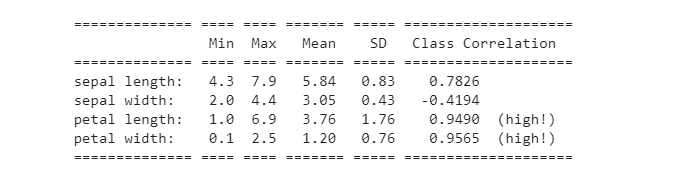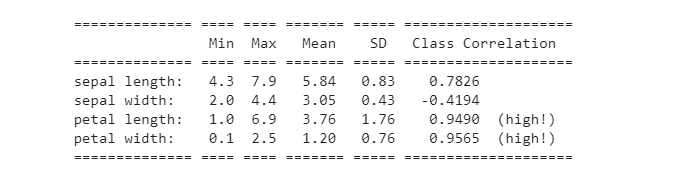))
2. Загрузить в PySpark.
3. При помощи VectorAssembler преобразовать все колонки с признаками в одну (использовать Pipeline — опционально).
4. Разбить данные на train и test.
5. Создать модель логистической регреcсии или модель дерева и обучить её.
6. Воспользоваться MulticlassClassificationEvaluator для оценки качества на train и test множестве.

Установка Spark

In [ ]:
# Обновляем пакеты системы с помощью apt-get update
!apt-get update

In [198]:
# Устанавливаем OpenJDK 8 с помощью apt-get install.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [199]:
# Скачиваем архив Spark с официального сайта с помощью wget.
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

In [ ]:
# Распаковываем архив Spark с помощью tar -xvf.
!tar -xvf spark-3.5.0-bin-hadoop3.tgz

In [201]:
# Устанавливаем findspark с помощью pip install.
!pip install -q findspark

In [202]:
# Устанавливаем переменные окружения JAVA_HOME и SPARK_HOME для работы с Spark.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [203]:
# Инициализируем findspark для работы с Spark.
import findspark
findspark.init()

# Создаем экземпляр SparkSession для работы с Spark.
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Получаем контекст SparkContext для работы с Spark.
sc = spark.sparkContext

### Загрузите данные при помощи spark.read.csv из приложенного файла


Набор данных растений ириса


**Характеристики набора данных:**

    :Количество экземпляров: 150 (по 50 в каждом из трёх классов)
    :Количество атрибутов: 4 числовых, прогнозируемых атрибута и класс.
    :Информация об атрибутах:
        - sepal length - длина чашелистика в см
        - sepal width - ширина чашелистика в см
        - petal length - длина лепестка в см
        - petal width - ширина лепестка в см
        - Класс:
                - 0-Setosa
                - 1-Versicolour
                - 2-Virginica


In [204]:
# Загрузка данных: Данные загружаются из файла 'iris.CSV' в датафрейм Spark
# с помощью метода read.csv(). Параметры inferSchema=True и header=True
# используются для автоматического определения схемы данных и загрузки заголовка CSV-файла соответственно.

df=spark.read.csv('iris.CSV', inferSchema=True, header=True)

In [ ]:
# Отображаем первые 5 строк датафрейма.
df.show(150)

### При помощи VectorAssembler преобразовать все колонки с признаками в одну (использовать Pipeline — опционально).


In [206]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# В данном коде мы импортируем модули Vectors и VectorAssembler из PySpark.
# Модуль Vectors содержит классы и функции для работы с векторами признаков,
# а модуль VectorAssembler используется для сборки признаков в вектор.

In [207]:
# Метод df.columns возвращает список столбцов датафрейма df.

df.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'variety',
 'variety_num']

In [208]:
# Преобразование признаков:
# Функция VectorAssembler используется для преобразования признаков
# 'sepal_length', 'sepal_width', 'petal_length', 'petal_width' в вектор признаков 'Features'.

assembler = VectorAssembler(inputCols=[
 'sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 ], outputCol='Features')

In [209]:
df = assembler.transform(df)

# В данном коде мы применяем функцию VectorAssembler к датафрейму df с помощью метода transform().
# Метод transform() применяет функцию к каждому ряду датафрейма и возвращает новый датафрейм с преобразованными данными.
# В результате применения VectorAssembler к df, мы получаем новый датафрейм, в котором все признаки
# 'sepal_length', 'sepal_width', 'petal_length', 'petal_width' объединены в один столбец 'Features'.

In [226]:
df.show(5)

+------------+-----------+------------+-----------+-------+-----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|variety|variety_num|         Features|
+------------+-----------+------------+-----------+-------+-----------+-----------------+
|         5.1|        3.5|         1.4|        0.2| Setosa|          0|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2| Setosa|          0|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2| Setosa|          0|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2| Setosa|          0|[4.6,3.1,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2| Setosa|          0|[5.0,3.6,1.4,0.2]|
+------------+-----------+------------+-----------+-------+-----------+-----------------+
only showing top 5 rows



### Разобьем данные на данные для обучения и проверки

In [211]:
train, test = df.randomSplit([0.8, 0.2], seed=12345)

# Разбиение данных на обучающую и тестовую выборки:
# Метод randomSplit() используется для случайного разделения датафрейма
# на обучающую и тестовую выборки с заданными пропорциями.

#В данном случае, 80% данных используется для обучения, а 20% - для тестирования.

# Параметр seed=12345 в методе randomSplit()
# используется для задания начального значения генератора случайных чисел.

# Это позволяет получить воспроизводимые результаты разделения данных на обучающую и тестовую выборки.
# Если вы используете один и тот же код и зададите тот же seed, то получите одни и те же случайные числа,
# и, следовательно, одни и те же обучающую и тестовую выборки

In [227]:
train.show(5)

+------------+-----------+------------+-----------+-------+-----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|variety|variety_num|         Features|
+------------+-----------+------------+-----------+-------+-----------+-----------------+
|         4.3|        3.0|         1.1|        0.1| Setosa|          0|[4.3,3.0,1.1,0.1]|
|         4.4|        2.9|         1.4|        0.2| Setosa|          0|[4.4,2.9,1.4,0.2]|
|         4.4|        3.0|         1.3|        0.2| Setosa|          0|[4.4,3.0,1.3,0.2]|
|         4.4|        3.2|         1.3|        0.2| Setosa|          0|[4.4,3.2,1.3,0.2]|
|         4.5|        2.3|         1.3|        0.3| Setosa|          0|[4.5,2.3,1.3,0.3]|
+------------+-----------+------------+-----------+-------+-----------+-----------------+
only showing top 5 rows



### Создадим и обучим модель логистической регрессии

In [228]:
from pyspark.ml.classification import LogisticRegression

# В данном коде мы импортируем класс LogisticRegression из модуля pyspark.ml.classification.
# Класс LogisticRegression используется для обучения модели логистической регрессии.

In [229]:
lr = LogisticRegression(featuresCol = 'Features', labelCol = 'variety_num')
lrModel = lr.fit(train)

# Обучение модели логистической регрессии:
# Создается экземпляр класса LogisticRegression
# с указанием столбца признаков 'Features' и столбца меток 'variety_num'.

# Затем модель обучается на обучающей выборке с помощью метода fit().

In [230]:
train_res = lrModel.transform(train)
test_res = lrModel.transform(test)

# В данном коде мы применяем обученную модель логистической регрессии lrModel
# к обучающей выборке train и тестовой выборке test с помощью метода transform().

# Метод transform() применяет модель к данным и возвращает новый датафрейм с предсказаниями модели.
# В результате, мы получаем датафреймы train_res и test_res, которые содержат исходные данные и предсказания модели для каждой строки.

In [231]:
df_pandas = train_res.toPandas()
df_pandas.head(1)

# Данный код преобразует датафрейм train_res из PySpark в pandas.DataFrame с помощью метода toPandas().
# Затем он выводит на экран первую строку преобразованного датафрейма с помощью метода head(1).
# Этот код позволяет просмотреть первые несколько строк датафрейма train_res как полноценный датафрейм в pandas.

,sepal_length,sepal_width,petal_length,petal_width,variety,variety_num,Features,rawPrediction,probability,prediction
0,4.3,3.0,1.1,0.1,Setosa,0,"[4.3, 3.0, 1.1, 0.1]","[67.70279195875312, -5.483728693221446, -62.21...","[1.0, 1.642471835404166e-32, 3.764048385223648...",0.0


1. Значения `rawPrediction` представляют собой скалярное произведение вектора признаков и вектора коэффициентов модели.

* `67.70279195875312` - это предсказание модели для класса `Setosa`.

* `-5.483728693221446` - это предсказание модели для класса `Versicolor`.

* `-62.21906326553166` - это предсказание модели для класса `Virginica`.

Чем больше это значение, тем больше вероятность того, что наблюдение принадлежит к соответствующему классу.


2. Pначения `probability` представляют собой вероятности принадлежности каждого наблюдения к каждому из классов.

* `1.0` - это вероятность принадлежности наблюдения к классу `Setosa`.

* `1.642471835404166e-32` - это вероятность принадлежности наблюдения к классу `Versicolor`.


* `3.764048385223648e-57` - это вероятность принадлежности наблюдения к классу `Virginica`.

Это значение может быть интерпретировано как степень уверенности модели в принадлежности данного наблюдения к классу. Чем ближе значение к 1, тем больше вероятность того, что наблюдение принадлежит к соответствующему классу.

3. `prediction` - это предсказанный класс для каждого наблюдения. В данном случае, наблюдение было предсказано как класс `Setosa`.



### Оценим качество

Для оценки качества предсказания в spark реализованно несколько классов

Если мы решаем задачу бинарной классификации (то есть классов - 2),

то нам подойдет `BinaryCLassificationEvaluator`,

а если классов больше 2-х, то `MulticlassClassificationEvaluator`

In [232]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Библиотека pyspark.ml.evaluation содержит классы и функции
# для оценки качества моделей машинного обучения в PySpark.

# В данном случае, мы используем класс MulticlassClassificationEvaluator
# для оценки качества модели логистической регрессии на основе метрики точности.

In [233]:
ev = MulticlassClassificationEvaluator(labelCol='variety_num')

# Оценка качества модели: Для оценки качества модели используется MulticlassClassificationEvaluator.
# Создается экземпляр класса MulticlassClassificationEvaluator с указанием столбца меток 'variety_num'.

In [234]:
# Метод evaluate() применяется к результатам обучения и тестирования модели. Значение точности выводится на экран.

ev.evaluate(train_res)
print("Точность модели на обучающей выборке: %.2f" % ev.evaluate(train_res))

ev.evaluate(test_res)
print("Точность модели на тестовой выборке: %.2f" % ev.evaluate(test_res))

Точность модели на обучающей выборке: 0.98
Точность модели на тестовой выборке: 1.00


### Обучите модель дерева решений и оцените его качество





In [220]:
from pyspark.ml.classification import DecisionTreeClassifier

In [221]:
tr = DecisionTreeClassifier(featuresCol='Features', labelCol='variety_num')
trFitted = tr.fit(train)

# Обучение модели дерева решений:
# Аналогично предыдущему шагу, создается экземпляр класса DecisionTreeClassifier
# с указанием столбца признаков 'Features' и столбца меток 'variety_num'.
# Затем модель обучается на обучающей выборке с помощью метода fit().

In [222]:
train_tr_res=trFitted.transform(train)
test_tr_res=trFitted.transform(test)

# В данном коде мы применяем обученную модель логистической регрессии lrModel
# к обучающей выборке train и тестовой выборке test с помощью метода transform().

In [236]:
train_tr_res.show(5)

+------------+-----------+------------+-----------+-------+-----------+-----------------+--------------+-------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|variety|variety_num|         Features| rawPrediction|  probability|prediction|
+------------+-----------+------------+-----------+-------+-----------+-----------------+--------------+-------------+----------+
|         4.3|        3.0|         1.1|        0.1| Setosa|          0|[4.3,3.0,1.1,0.1]|[43.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|         4.4|        2.9|         1.4|        0.2| Setosa|          0|[4.4,2.9,1.4,0.2]|[43.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|         4.4|        3.0|         1.3|        0.2| Setosa|          0|[4.4,3.0,1.3,0.2]|[43.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|         4.4|        3.2|         1.3|        0.2| Setosa|          0|[4.4,3.2,1.3,0.2]|[43.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|         4.5|        2.3|         1.3|        0.3| Setosa|          0|[4.5,2.3,1.3,0.3]|[

In [225]:
# Метод evaluate() применяется к результатам обучения и тестирования модели. Значение точности выводится на экран.

ev.evaluate(train_tr_res)
print("Точность модели дерева решений на обучающей выборке: %.2f" % ev.evaluate(train_tr_res))

ev.evaluate(test_tr_res)
print("Точность модели дерева решений на тестовой выборке: %.2f" % ev.evaluate(test_tr_res))

Точность модели дерева решений на обучающей выборке: 0.99
Точность модели дерева решений на тестовой выборке: 1.00


По результатам оценки моделей логистической регрессии и дерева решений с использованием библиотеки PySpark можно сделать следующие выводы:

1. Модель логистической регрессии показала высокую точность на обучающей выборке (98%) и отличную точность на тестовой выборке (100%). Это говорит о том, что модель хорошо обобщает данные и способна делать точные прогнозы как на известных, так и на новых данных.

2. Модель дерева решений также продемонстрировала высокую точность на обучающей выборке (99%) и отличную точность на тестовой выборке (100%). Это указывает на то, что модель дерева решений эффективно обучается на данных и хорошо обобщает информацию для делания точных прогнозов.

Обе модели показали высокие показатели точности как на обучающей, так и на тестовой выборках, что свидетельствует о их хорошей способности к классификации. Однако, у модели логистической регрессии наблюдается небольшое снижение точности на тестовой выборке по сравнению с обучающей, в то время как у модели дерева решений точность остается на одном уровне. Таким образом, обе модели могут быть использованы для классификации данных, но стоит учитывать особенности каждой из них при принятии окончательного решения.